In [2]:
import glob, os, pandas as pd, numpy as np, cv2
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
#
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch import nn
import torch
import torch.nn.functional as F
#
import pytorch_lightning as pl
import wandb
from tqdm.auto import tqdm
#
from cnn_lstm_util.dataIndex import dataIndexing
from cnn_lstm_util.preProcess import filter_to_valid_seq_dataindex, compute_im_stats, load_img_df
from cnn_lstm_util.dataGenerator import VideoSequenceData, VideoSequenceDataModule
from cnn_lstm_util.models import CNN_LSTM

In [3]:
%load_ext autoreload
%autoreload 2
#
class PATH_args:
    proj_path = Path('./').absolute()
    data_path = proj_path.parent/proj_path.name/'data'
    dataindex_path = data_path/'data_index.csv'
    model_chkpt_path = data_path/'model_chkpt'

    print({k: v for k,v in locals().items() if not k.startswith('_')}, sep='\n')
wandb.login()

{'proj_path': WindowsPath('C:/Users/Me-Biotrillion/BioTrillion Dropbox/Projects/Sandbox Employees (Internal)/Matthew Mo/video_sequence_model'), 'data_path': WindowsPath('C:/Users/Me-Biotrillion/BioTrillion Dropbox/Projects/Sandbox Employees (Internal)/Matthew Mo/video_sequence_model/data'), 'dataindex_path': WindowsPath('C:/Users/Me-Biotrillion/BioTrillion Dropbox/Projects/Sandbox Employees (Internal)/Matthew Mo/video_sequence_model/data/data_index.csv'), 'model_chkpt_path': WindowsPath('C:/Users/Me-Biotrillion/BioTrillion Dropbox/Projects/Sandbox Employees (Internal)/Matthew Mo/video_sequence_model/data/model_chkpt')}


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 3m-m. Use `wandb login --relogin` to force relogin


True

In [4]:
indexer = dataIndexing()
# indexer.main(folder=PATH_args.data_path, stratify_cols='video', 
#              data_splits={'train':0.7, 'val':0.1, 'test':0.2}, selected_folders=['initial_train'])

In [5]:
data_index_df = pd.read_csv(PATH_args.dataindex_path, index_col='name')
print(data_index_df.shape, data_index_df['set'].value_counts(), sep='\n')
data_index_df.head(2)

(1334, 18)
train    933
test     268
val      133
Name: set, dtype: int64


,video,frames,face_side,x_img-path,y_img-path,y_input_img-path,coord_p_true_x,coord_p_true_y,radiusX_p_true,radiusY_p_true,theta_p_true,coord_i_true_x,coord_i_true_y,radiusX_i_true,radiusY_i_true,theta_i_true,PIR,set
name,,,,,,,,,,,,,,,,,,
2021Q3_036_left_0000.png,2021Q3_036_left,0,left,C:\Users\Me-Biotrillion\BioTrillion Dropbox\Pr...,C:\Users\Me-Biotrillion\BioTrillion Dropbox\Pr...,C:\Users\Me-Biotrillion\BioTrillion Dropbox\Pr...,112.500,66.1300,12.03,12.03,-0.1,110.42,68.39,45.28,45.28,-0.25,0.26568,test
2021Q3_036_left_0001.png,2021Q3_036_left,1,left,C:\Users\Me-Biotrillion\BioTrillion Dropbox\Pr...,C:\Users\Me-Biotrillion\BioTrillion Dropbox\Pr...,C:\Users\Me-Biotrillion\BioTrillion Dropbox\Pr...,112.085,65.9125,12.03,12.03,-0.1,110.15,67.95,45.28,45.28,-0.25,0.26568,val


In [62]:
ex_im_y = load_img_df(data_index_df.iloc[0:1], im_col='y_img-path')
ex_im_x = load_img_df(data_index_df.iloc[0:1], im_col='x_img-path')
print(ex_im_x.max(), ex_im_x.min(), ex_im_y.max(), ex_im_x.shape, ex_im_y.shape)

load_img_df dtype: uint8
load_img_df dtype: uint8
221 1 3 (1, 160, 224, 3) (1, 160, 224, 1)


In [63]:
seq_dataindex_df = filter_to_valid_seq_dataindex(data_index_df, vid_col='video', seq_len=40)
print(seq_dataindex_df.shape, seq_dataindex_df['set'].value_counts(), sep='\n')
seq_dataindex_df.head(2)

(1174, 18)
train    824
test     238
val      112
Name: set, dtype: int64


,video,frames,face_side,x_img-path,y_img-path,y_input_img-path,coord_p_true_x,coord_p_true_y,radiusX_p_true,radiusY_p_true,theta_p_true,coord_i_true_x,coord_i_true_y,radiusX_i_true,radiusY_i_true,theta_i_true,PIR,set
name,,,,,,,,,,,,,,,,,,
2021Q3_036_left_0000.png,2021Q3_036_left,0,left,C:\Users\Me-Biotrillion\BioTrillion Dropbox\Pr...,C:\Users\Me-Biotrillion\BioTrillion Dropbox\Pr...,C:\Users\Me-Biotrillion\BioTrillion Dropbox\Pr...,112.500,66.1300,12.03,12.03,-0.1,110.42,68.39,45.28,45.28,-0.25,0.26568,test
2021Q3_036_left_0001.png,2021Q3_036_left,1,left,C:\Users\Me-Biotrillion\BioTrillion Dropbox\Pr...,C:\Users\Me-Biotrillion\BioTrillion Dropbox\Pr...,C:\Users\Me-Biotrillion\BioTrillion Dropbox\Pr...,112.085,65.9125,12.03,12.03,-0.1,110.15,67.95,45.28,45.28,-0.25,0.26568,val


### Dataset & Loader

In [7]:
class TASK_args:
    mode = 'SEG-REG'
    seed = 101
    
class DATA_args:
    mode = TASK_args.mode
    y_reg_cols = [
        'coord_p_true_x', 'coord_p_true_y',
        'radiusX_p_true', 'radiusY_p_true',
        'coord_i_true_x', 'coord_i_true_y',
        'radiusX_i_true', 'radiusY_i_true']
    sequence_settings={
        'sequence_length':41, 'mode': 'middle','sequence_gap': 40, 'frames_gap':0
    }
    transform_settings = {
        'augment': True,
        'target_resize': None,
        'pad_resize': (224,224),
        'normalize': True,
        #'recompute_normalization': False
    }
    batch_size = 8
    
if TASK_args.seed: torch.manual_seed(TASK_args.seed)

In [36]:
# Check dataloader
print(f'find dataset')
sclera_video_dataset = VideoSequenceData(
    dataindex_df=data_index_df, seq_start_idx=seq_dataindex_df.index, **DATA_args.__dict__, 
    debug=True
)
print(f'find dataloader')
loader = DataLoader(
    sclera_video_dataset,
    batch_size=DATA_args.batch_size,
    #num_workers=1, (will crash Window systems)
    shuffle=True,
)

find dataset
dataindex shape: (1334, 18), legal dataindex shape:(1174, 18)
Number of additional augmentation targets:40
Mode:SEG-REG. Number of image classes: 4
find dataloader


In [37]:
# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(loader):
    print(i_batch, sample_batched['image'].shape, sample_batched['mask'].shape)
    print(f"stat: {sample_batched['image'].min(), sample_batched['image'].max()}, \
          {sample_batched['mask'].min(), sample_batched['mask'].max()}")
    break

(41, 160, 224, 3) uint8 255 24
y_mask shape: (160, 224)
Augmented shapes:((41, 3, 224, 224), (4, 224, 224))
Post-aug stat: (-1.7030811, 2.6399999), (0, 1)
(41, 160, 224, 3) uint8 255 0
y_mask shape: (160, 224)
Augmented shapes:((41, 3, 224, 224), (4, 224, 224))
Post-aug stat: (-2.117904, 2.64), (0, 1)
(41, 160, 224, 3) uint8 255 23
y_mask shape: (160, 224)
Augmented shapes:((41, 3, 224, 224), (4, 224, 224))
Post-aug stat: (-1.7197534, 2.64), (0, 1)
(41, 160, 224, 3) uint8 255 25
y_mask shape: (160, 224)
Augmented shapes:((41, 3, 224, 224), (4, 224, 224))
Post-aug stat: (-1.5699118, 2.6225708), (0, 1)
(41, 160, 224, 3) uint8 255 0
y_mask shape: (160, 224)
Augmented shapes:((41, 3, 224, 224), (4, 224, 224))
Post-aug stat: (-2.117904, 2.6399999), (0, 1)
(41, 160, 224, 3) uint8 255 0
y_mask shape: (160, 224)
Augmented shapes:((41, 3, 224, 224), (4, 224, 224))
Post-aug stat: (-2.1179042, 2.64), (0, 1)
(41, 160, 224, 3) uint8 255 28
y_mask shape: (160, 224)
Augmented shapes:((41, 3, 224, 224

Visualizations:


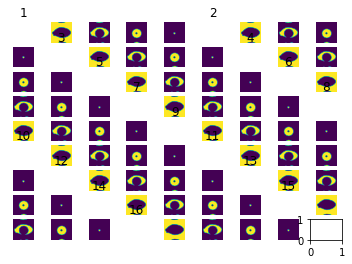

In [10]:
# observe 4th batch and stop.
print("Visualizations:")
if i_batch == 0:
    multi=5
    n_max = min(DATA_args.sequence_settings.get('sequence_length')*multi, 80)
    grid_n = int(np.ceil(np.sqrt(n_max)))
    fig, ax = plt.subplots(grid_n, grid_n); ax = ax.ravel()
    for n in range(0, n_max, multi):
        ax[n].axis('off'); ax[n].set_title(f'{n//multi+1}')
        im = sample_batched['image'][0][n//5].numpy()  # img
        #ax[n].imshow(np.moveaxis(im, 0, -1).astype('float'))
        # mask
        for ii in range(sample_batched['mask'][0].shape[0]):
            ax[n+1+ii].axis('off')
            ax[n+1+ii].imshow(sample_batched['mask'][0][ii].numpy()==1)

## Model

In [8]:
from cnn_lstm_util.models import CNN_LSTM, CNN, CNN_head_custom
from cnn_lstm_util.metrics import METRICS, CALLBACKS
#from torchsummary import summary
from torchinfo import summary

In [9]:
class MODEL_args:
    input_shape=(3,)+DATA_args.transform_settings.get('pad_resize')
    lstm_settings = {
        'input_size':960, 
        'hidden_size':64, 
        'num_layers':1
    }
    n_seg_class = 3
    n_reg_var = len(DATA_args.y_reg_cols)
    metrics = ['Jaccard']
    mode = TASK_args.mode

class TRAIN_args:
    accelerator='cpu'
    devices = 1
    max_epochs = 3
    callbacks = CALLBACKS(model_chkpt_dir=PATH_args.model_chkpt_path
        ).select_callbacks(['Model Checkpoint','EarlyStopping','GradientAccumulationScheduler'])
    logger = pl.loggers.WandbLogger(project='biotrillion',  entity="3m-m", job_type='train')

In [56]:
# DEFAULT (ie: no accumulated grads)

model = CNN_LSTM(cnn_head_model=CNN_head_custom('mobilenetv3'), **MODEL_args.__dict__)
datamodule = VideoSequenceDataModule(PATH_args.dataindex_path, seq_dataindex_df=seq_dataindex_df, 
                                     **DATA_args.__dict__)
datamodule.setup()

trainer = pl.Trainer(**{k:v for k,v in TRAIN_args.__dict__.items() if not k.startswith('_')})
summary(model.cnn.to('cuda'), (1,3, 224, 224))
summary(model.to('cpu'),  input_size=(1, 16, 3, 224, 224))

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


CNN head output size:960
Sequence settings:{'sequence_length': 41, 'mode': 'middle', 'sequence_gap': 40, 'frames_gap': 0}
Arguments to be passed to dataloader: dict_keys(['mode', 'sequence_settings', 'x_img_col', 'y_img_col', 'y_reg_cols', 'transform_settings', 'debug', 'kwargs'])
Dataset subsets:['test', 'val', 'train', 'predict']
Mode:SEG-REG. Number of image classes: 4
Mode:SEG-REG. Number of image classes: 4
Mode:SEG-REG. Number of image classes: 4
Mode:SEG-REG. Number of image classes: 4


In [ ]:
trainer.fit(model, datamodule)

C:\ProgramData\Anaconda\Anaconda3\envs\ptml\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")

  | Name    | Type            | Params
--------------------------------------------
0 | cnn     | CNN_head_custom | 3.0 M 
1 | rnn     | LSTM            | 98.8 K
2 | lin_out | Linear          | 520   
--------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.285    Total estimated model params size (MB)


Dataset subsets:['test', 'val', 'train', 'predict']
Dataset subsets:['test', 'val', 'train', 'predict']


C:\ProgramData\Anaconda\Anaconda3\envs\ptml\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\ProgramData\Anaconda\Anaconda3\envs\ptml\lib\site-packages\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]